# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP1-DL-YOUR-SURNAME.ipynb') to Ecampus/Moodle before the deadline.


**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).

**Data**
You will have at your disposal the ISIC 2017 dataset (https://challenge.isic-archive.com/data/#2017) already pre-processed, resized and quality checked. It is divided into Training (N=2000), Validation (N=150) and Test (N=600) sets.

**Goal**
The goal of this practical session is to classify images of skin lesions as either benign (nevus or seborrheic_keratosis) or melanoma (binary classification) using machine and deep learning algorithms.

In the first part of the TP, you will manually compute some features relevant to the skin lesion classification (feature engineering) and then classify images using "classical" ML algorithms such as, logistic regression, SVM and Random Forests.

In the second part, you will test the features learnt with Deep Learning algorithms. You will first train from scratch well-known CNN architectures (VGG, ResNet, DenseNet, etc..) and then leverage the representations learnt by these networks on a pre-training from Imagenet (fine-tuning, full-restimation).

Please complete the code where you see **"XXXXXXXXX"** and answer the **Questions**


In [1]:
%%capture capt
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.io import imsave
from skimage.transform import resize
from skimage import color
from skimage import measure
from skimage import transform
from skimage.color import rgb2gray
from scipy import ndimage
from scipy import stats
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import torch
import glob
import cv2
from PIL import Image
from PIL import ImageShow

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset
from torchvision import models,transforms
!pip install torchmetrics
import torchmetrics

# torchvision
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

%matplotlib inline

IN_COLAB = True
!pip install gdown==4.6.0 # with the following versions, there is an error

You can either download the data from my Google Drive or work locally.

In [2]:
if IN_COLAB:
  print("you are using google colab")
  import gdown
  !mkdir ./data
  gdown.download(id="1iH5hkRN0wCgGklUN5df9u2Ue3UXAR4xZ", output='./data/TrainCropped.zip', quiet=False)
  !unzip -qu "./data/TrainCropped.zip" -d "./data"
  gdown.download(id="1lyRZuV9UST55AEqwSy4mqMmh5yHGI1FM", output='./data/TestCropped.zip', quiet=False)
  !unzip -qu "./data/TestCropped.zip" -d "./data"
  gdown.download(id="1RLJOmqAnHCgiJ7qShQurpxNaRhjjPpJb", output='./data/ValCropped.zip', quiet=False)
  !unzip -qu "./data/ValCropped.zip" -d "./data"
  !rm -rf ./data/TrainCropped.zip
  !rm -rf ./data/TestCropped.zip
  !rm -rf ./data/ValCropped.zip
  path='./data/'
else:
  print('You are NOT using colab')
  # we assume that folders of data are in the same folder as this jupyter notebook
  path='' # if you change this path , you should also change idTrain, idVal and idTest

you are using google colab


Downloading...
From: https://drive.google.com/uc?id=1iH5hkRN0wCgGklUN5df9u2Ue3UXAR4xZ
To: /content/data/TrainCropped.zip
100%|██████████| 31.6M/31.6M [00:00<00:00, 90.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lyRZuV9UST55AEqwSy4mqMmh5yHGI1FM
To: /content/data/TestCropped.zip
100%|██████████| 10.7M/10.7M [00:00<00:00, 143MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RLJOmqAnHCgiJ7qShQurpxNaRhjjPpJb
To: /content/data/ValCropped.zip
100%|██████████| 2.43M/2.43M [00:00<00:00, 78.2MB/s]


If there is an error (might happen with gdown) please upload the three files manually.
Follow the following instructions:
- go to the folder symbol on the left of your screen
- click on the three vertical dots on the 'data' folder
- upload (importer in french) the three folders
That's it !

In [3]:
# if IN_COLAB:
#   !unzip -qu "./data/TrainCropped.zip" -d "./data"
#   !unzip -qu "./data/TestCropped.zip" -d "./data"
#   !unzip -qu "./data/ValCropped.zip" -d "./data"
#   !rm -rf ./data/TrainCropped.zip
#   !rm -rf ./data/TestCropped.zip
#   !rm -rf ./data/ValCropped.zip
#   path='./data/'

For the Deep Learning part, we strongly suggest using GPU

In [4]:
if torch.cuda.is_available():
  print('Is there a GPU card?', torch.cuda.is_available(),'\nNumber of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
  print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))

Is there a GPU card? True 
Number of GPU cards:  1 
Which card GPU? Tesla T4
Total GPU memory 15.84 GB. Free GPU memory 15.73 GB


Let's load the data.

In [5]:
IN_COLAB = True

In [6]:
pathTrain=glob.glob(path + "TrainCropped/*.jpg")
#print(pathTrain)
idTrain=np.copy(pathTrain)
if IN_COLAB:
    for i in np.arange(len(idTrain)): idTrain[i]=idTrain[i][20:-4]
else:
    for i in np.arange(len(idTrain)): idTrain[i]=idTrain[i][13:-4]
#print(idTrain)
print('There are', len(idTrain), 'Train images')

There are 2000 Train images


In [7]:
pathVal=glob.glob(path + "ValCropped/*.jpg")
idVal=np.copy(pathVal)
if IN_COLAB:
    for i in np.arange(len(idVal)): idVal[i]=idVal[i][18:-4]
else:
    for i in np.arange(len(idVal)): idVal[i]=idVal[i][11:-4]
#print(idVal)
print('There are', len(idVal) , 'Validation images')

There are 150 Validation images


In [8]:
pathTest=glob.glob(path + "TestCropped/*.jpg")
idTest=np.copy(pathTest)
if IN_COLAB:
    for i in np.arange(len(idTest)): idTest[i]=idTest[i][19:-4]
else:
    for i in np.arange(len(idTest)): idTest[i]=idTest[i][12:-4]
#print(idTest)
print('There are', len(idTest) , 'Test images')

There are 600 Test images


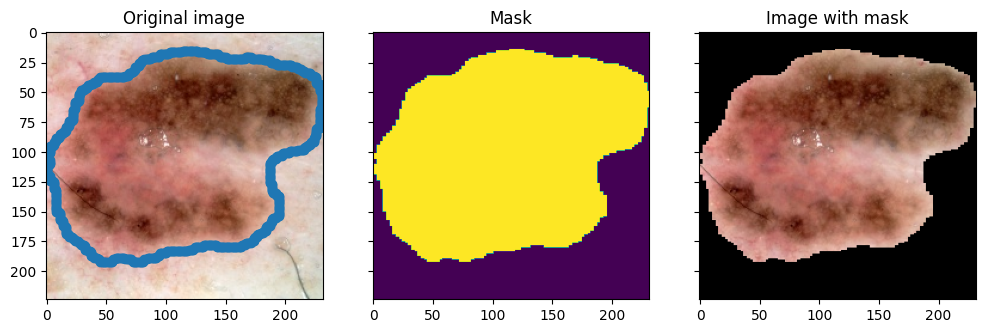

In [9]:
name_im = idTrain[np.random.choice(range(len(idTrain)))]
filename = path + 'TrainCropped/{}.jpg'.format(name_im)
image = imread(filename)
filename_Segmentation = path + 'TrainCropped/{}seg.png'.format(name_im)
image_Segmentation = imread(filename_Segmentation) # Value 0 or 255
image_Segmentation_boolean = (image_Segmentation/255).astype(np.uint8) # To get uint16
image_Segmentation_expand = np.expand_dims(image_Segmentation_boolean, axis=2)
image_mul_mask = (image_Segmentation_expand*image)
contours = cv2.findContours(image_Segmentation_boolean, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
contour = list(contours[0])
contour = np.squeeze(np.asarray(contour))

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(image)
grid[0].scatter(contour[:,0],contour[:,1])
#grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(image_Segmentation_boolean)
#grid[1].axis('off')
grid[1].set_title("Mask")
grid[2].imshow(image_mul_mask)
#grid[2].axis('off')
grid[2].set_title("Image with mask");

## Loading Metadata and Target values

You have at your disposal also two metadata, the age and the sex. If you want, you can use them as features in the classification but be careful ! There are missing values

We also load the target values (0 for benign and 1 for melanoma)

In [10]:
Metatrain = pd.read_csv('./data/TrainCropped/ISIC-2017_Training_Data_metadata.csv')
print(Metatrain.head(10))
Groundtrain = pd.read_csv('./data/TrainCropped/ISIC-2017_Training_Part3_GroundTruth.csv')

       image_id age_approximate     sex
0  ISIC_0000000              55  female
1  ISIC_0000001              30  female
2  ISIC_0000002              60  female
3  ISIC_0000003              30    male
4  ISIC_0000004              80    male
5  ISIC_0000006              25  female
6  ISIC_0000007              25  female
7  ISIC_0000008              30  female
8  ISIC_0000009              30  female
9  ISIC_0000010              35  female


In [11]:
def get_y(ids, Ground):
  Y = np.zeros(len(ids))
  for i, id in enumerate(ids):
    Y[i] = int(Ground.loc[Ground.image_id == id].melanoma.iloc[0])
  return Y

In [12]:
Ytrain = get_y(idTrain, Groundtrain)

In [13]:
Metaval = pd.read_csv('./data/ValCropped/ISIC-2017_Validation_Data_metadata.csv')
Groundval = pd.read_csv('./data/ValCropped/ISIC-2017_Validation_Part3_GroundTruth.csv')

Yval = get_y(idVal, Groundval)

In [14]:
Metatest = pd.read_csv('./data/TestCropped/ISIC-2017_Test_v2_Data_metadata.csv')
Groundtest = pd.read_csv('./data/TestCropped/ISIC-2017_Test_v2_Part3_GroundTruth.csv')

Ytest = get_y(idTest, Groundtest)

##Deep Learning
In this section, you will try simple Deep Learning strategies:
- Fine-tuning the last layer of a network already trained on Image-Net
- Re-training completely a network already trained on Image-Net
- Re-training from scratch a network that has already shown good performances on other data-sets (architecture transfer or inductive bias transfer)

You will have to use at least three different networks (e.g., ResNet, VGG, DenseNet)

**Please compute the full time (reading papers/tutorials, coding, computational time) you spend on this part. It will be asked at the end of the practical session**

Pytorch also offers two nice primitives for storing and working with datasets:

*   **Dataset** stores the images, labels and segmentation masks
*   **DataLoader** wraps an iterable around the elements of the Dataset

This is very practical since we can easily resize the images to the same size (important for DL) and multiply image and segmentation masks. Here, you have an exemple.

In [15]:
class ISICDataset(Dataset):
    def __init__(self, pathlist, targets, size=(224,224)):
        self.image_paths = pathlist
        self.mask_paths = [ p[:-4]+'seg.png' for p in pathlist ]
        self.targets = torch.LongTensor(targets)
        self.size=size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        y = self.targets[idx]

        x = Image.open(img_path).resize(self.size, Image.BILINEAR) # all images are resized to (224,224)
        s = Image.open(mask_path).resize(self.size, Image.NEAREST) # all segmentation masks are resized to (224,224)

        # Multiply image and segmentation mask
        blank = x.point(lambda _: 0)
        c = Image.composite(x, blank, s)

        # Send to tensor
        x = TF.to_tensor(x)
        c = TF.to_tensor(c)

        # Normalize according to ImageNet statistics
        x = TF.normalize(x,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        c = TF.normalize(c,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

        return x, c, y


Another reason why DataSets and DataLoaders are practical is that we can automatically apply data augmentation strategies. For instance, if we want to automatically apply (the same) data augmentations to both images and segmentations, we can use:

In [16]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


class ISICDatasetWithAug(Dataset):
    def __init__(self, pathlist, targets, size=(224,224)):
        self.image_paths = pathlist
        self.mask_paths = [ p[:-4]+'seg.png' for p in pathlist ]
        self.targets = torch.LongTensor(targets)
        self.size=size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        y = self.targets[idx]

        x = Image.open(img_path).resize(self.size, Image.BILINEAR) # all images are resized to (224,224)
        s = Image.open(mask_path).resize(self.size, Image.NEAREST) # all segmentation masks are resized to (224,224)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(x, output_size=(128, 128))
        x = TF.crop(x, i, j, h, w)
        s = TF.crop(s, i, j, h, w)

        # Random horizontal flipping
        if np.random.random() > 0.5:
          x = TF.hflip(x)
          s = TF.hflip(s)

        # Random vertical flipping
        if np.random.random() > 0.5:
            x = TF.vflip(x)
            s = TF.vflip(s)

        # Random rotation
        angle=np.random.randint(-90, 90)
        x=TF.rotate(x, angle, InterpolationMode.BILINEAR)
        s=TF.rotate(s,angle, InterpolationMode.NEAREST)

        # Multiply image and segmentation mask
        blank = x.point(lambda _: 0)
        c = Image.composite(x, blank, s)

        # Send to tensor
        x = TF.to_tensor(x)
        c = TF.to_tensor(c)

        # Normalize according to ImageNet statistics
        x = TF.normalize(x,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        c = TF.normalize(c,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

        return x, c, y

You have probably noticed that there are three outputs.

**Question**: Explain what they are and which data augmentations we are computing.

• x is the original image after applying random cropping, horizontal flipping, vertical flipping, and random rotation, which are:

   - Random Crop: A random crop of size (128, 128) (half of the size of the original image )is applied to both the image and the segmentation mask.
   -Random Horizontal Flipping: With a 50% probability, the image and the segmentation mask are horizontally flipped.
   -Random Vertical Flipping: With a 50% probability, the image and the segmentation mask are vertically flipped.
   -Random Rotation: The image and the segmentation mask are rotated by a random angle in the range of [-90, 90] degrees.

• c is the composite image obtained by multiplying (*i.e.* combining) the original image x with the segmentation mask. This step is performed after the random cropping, flipping, and rotation. The goal is to apply the same set of transformations to both the image and its corresponding segmentation mask.

Finally, the images x and c are converted to PyTorch tensors and normalized using the ImageNet statistics.

• y is the target label associated with the image.

Then, we can load the data

In [17]:
# to make the results reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

# Ensure that you are using GPU
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [18]:
batch_size = 128 # adapted to the Google Colab GPU
num_epochs = 300 # to be modified
learning_rate = 1e-5 # to be modified

train_dataset = ISICDataset(pathTrain, Ytrain)
val_dataset=ISICDataset(pathVal, Yval)
test_dataset=ISICDataset(pathTest, Ytest)

train_loader = DataLoader(train_dataset, num_workers=1, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, num_workers=1, batch_size=batch_size)
test_loader = DataLoader(test_dataset, num_workers=1, batch_size=batch_size)

In [19]:
num_classes = 1 # since we use the BCEWithLogitsLoss, we only have one output (if you were using CrossEntropy Loss, num_classes would be 2)

The first part will be about fine-tuning the last layer of a network already pre-trained on Image-Net. Here it is the code:

Then, we can train this last layer on the training data. Find the best model in the validation set and evaluate the generalization performance on the test set. If you look for the best hyper-parameter, you should also use the validation set.

In [20]:
from tqdm import tqdm
from IPython.display import display, clear_output

In [21]:
def early_stopping(losses, min_loss, patience):
    """
    Perform early stopping based on the given loss values.

    Parameters:
    - losses (list): List of loss values over epochs.
    - patience (int): Number of epochs with no improvement after which training will be stopped.

    Returns:
    - stop_training (bool): True if training should be stopped, False otherwise.
    """

    if len(losses) < patience + 1:
        return False

    recent_losses = losses[-patience:]

    return all(loss > min_loss for loss in recent_losses)

In [22]:
def validate(model, criterion, train_with_composites, min_loss, val_losses, val_aucs, val_accs,
             val_loader=val_loader, val_dataset=val_dataset):
  auc = torchmetrics.AUROC(task='binary',num_classes=2, average = 'macro').to(device)
  accuracy = torchmetrics.Accuracy(task='binary',num_classes = 2, average='micro').to(device)

  all_preds=[]
  all_labels=[]
  # Validation
  model.eval()
  auc.reset()
  accuracy.reset()
  val_loss = 0.
  with torch.no_grad():
      for images, composite, labels in (val_loader):
          if train_with_composites:
            outputs = model(composite.float().to(device))
          else:
            outputs = model(images.float().to(device))
          loss = criterion(outputs.squeeze(), labels.float().to(device))
          val_loss += loss.item() * (composite.size(0) if train_with_composites else images.size(0))
          preds=torch.sigmoid(outputs).squeeze()
          auc.update(preds, labels.to(device))
          accuracy.update(preds, labels.to(device))
  val_loss = val_loss / len(val_dataset)
  min_loss = min(min_loss, val_loss)
  val_losses.append(val_loss)
  val_auc = auc.compute()
  val_acc = accuracy.compute()
  val_aucs.append(val_auc.item())
  val_accs.append(val_acc.item())
  return min_loss

In [23]:
def compute_class_weights(loader, alpha=1):
    class_counts = torch.zeros(2)
    total_samples = 0

    for _, _, labels in loader:
        class_counts += torch.tensor([torch.sum(labels == 0), torch.sum(labels == 1)])
        total_samples += labels.size(0)

    class_weights = total_samples / (alpha * class_counts)
    return class_weights

In [24]:
def train_model(model, num_epochs, learning_rate, patience, print_every=None, pos_weight=5.347593582887701, alpha_class_weight=1,
                train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
                train_with_composites=True, test_on_lowest=False):

  min_loss = np.inf
  train_losses, train_aucs, train_accs = [], [], []
  val_losses, val_aucs, val_accs = [], [], []
  test_values = (np.inf, 0, 0, 0)

  if print_every is None:
    print_every = 1 if num_epochs < 10 else num_epochs / 10
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  if pos_weight is None:
    class_weights = compute_class_weights(train_loader, alpha=alpha_class_weight)
    pos_weight = class_weights[1]
  criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([pos_weight]).to(device))
  auc = torchmetrics.AUROC(task='binary',num_classes=2, average = 'macro').to(device)
  accuracy = torchmetrics.Accuracy(task='binary',num_classes = 2, average='micro').to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # Training
  for epoch in range(num_epochs):
    model.train()
    auc.reset()
    accuracy.reset()
    train_loss = 0.
    for images, composite, labels in (train_loader):
        optimizer.zero_grad()
        if train_with_composites:
          outputs = model(composite.float().to(device))
        else:
          outputs = model(images.float().to(device))
        preds=torch.sigmoid(outputs).squeeze()
        auc.update(preds, labels.to(device))
        accuracy.update(preds, labels.to(device))
        loss = criterion(outputs.squeeze(), labels.float().to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * (composite.size(0) if train_with_composites else images.size(0))
    train_loss = train_loss / len(train_dataset)
    train_losses.append(train_loss)
    train_auc = auc.compute().item()
    train_aucs.append(train_auc)
    train_acc = accuracy.compute().item()
    train_accs.append(train_acc)

    min_loss = validate(model, criterion, train_with_composites, min_loss, val_losses, val_aucs, val_accs, val_loader=val_loader, val_dataset=val_dataset)

    if min_loss == val_losses[-1] and test_on_lowest:
      test_loss, test_auc, test_acc = test_model(model, criterion=criterion, pos_weight=pos_weight, train_loader=train_loader, test_loader=test_loader, on_composites=False, print_=False)
      test_values = (test_loss, test_auc, test_acc, epoch)

    if epoch % print_every == 0 or epoch == num_epochs-1:
      print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Train AUC: {:.4f}, Val AUC: {:.4f}, Train Acc: {:.4f}, Val Acc: {:.4f}'.format(epoch+1,
                                                                                                                                                  num_epochs, train_loss, val_losses[-1], train_auc, val_aucs[-1], train_acc, val_accs[-1]))

    if early_stopping(val_losses, min_loss, patience):
      print(f'Epoch {epoch+1}: Early Stopping!')
      break

  if test_on_lowest:
    return train_losses, train_aucs, train_accs, val_losses, val_aucs, val_accs, test_values, pos_weight
  return train_losses, train_aucs, train_accs, val_losses, val_aucs, val_accs, pos_weight

In [25]:
def plot_training(train_losses, train_aucs, train_accs, val_losses, val_aucs, val_accs, suptitle=''):
  fig, axs = plt.subplots(1, 3, figsize=(12, 4))

  def plot(trains, vals, i, title):
    axs[i].plot(trains, label='Train')
    axs[i].plot(vals, label='Validation')
    axs[i].legend()
    axs[i].set_title(title)
    axs[i].grid('on')

  plot(train_losses, val_losses, 0, 'Loss')
  plot(train_aucs, val_aucs, 1, 'AUC')
  plot(train_accs, val_accs, 2, 'Accuracy')
  plt.suptitle(suptitle)
  plt.tight_layout();

In [26]:
def test_model(model, criterion=None, pos_weight=5.347593582887701, train_loader=train_loader, test_loader=test_loader, on_composites=False, print_=True):
  ### Testing
  auc = torchmetrics.AUROC(task='binary',num_classes=2, average = 'macro').to(device)
  accuracy = torchmetrics.Accuracy(task='binary',num_classes = 2, average='micro').to(device)
  if criterion is None:
      if pos_weight is None:
        class_weights = compute_class_weights(train_loader)
        pos_weight = class_weights[1]
      criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([pos_weight]).to(device))

  model.eval()
  auc.reset()
  accuracy.reset()
  test_loss=0
  with torch.no_grad():
      for images, composite, labels in (test_loader):
          if on_composites:
            outputs = model(composite.float().to(device))
          else:
            outputs = model(images.float().to(device))
          loss = criterion(outputs.squeeze(), labels.float().to(device))
          test_loss += loss.item() * (composite.size(0) if on_composites else images.size(0))
          preds=torch.sigmoid(outputs).squeeze()
          auc.update(preds, labels.to(device))
          accuracy.update(preds, labels.to(device))
  test_loss = test_loss / len(test_dataset)
  test_auc = auc.compute().item()
  test_acc = accuracy.compute().item()
  if print_:
    print('\nTest Loss: {:.4f}, Test AUC: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_auc, test_acc))
  return test_loss, test_auc, test_acc

In [ ]:
# Load a pre-trained ResNet-18 model
resnet18 = models.resnet18(weights='IMAGENET1K_V1')
# Freeze all parameters of the model
for param in resnet18.parameters():
    param.requires_grad = False
# Change last layer, the fully connected layer (classifier)
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.1MB/s]


In [ ]:
model=resnet18.float().to(device) # use float32 to save a bit of memory

# pos_weight is N_Train/sum(Ytrain) -> why in your opinion ?
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([5.347593582887701]).to(device))
# auc = torchmetrics.AUROC(task='binary',num_classes=2, average = 'macro').to(device)
# accuracy = torchmetrics.Accuracy(task='binary',num_classes = 2, average='micro').to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor # use float32 to save a bit of memory

In [ ]:
# we put a very large number of epochs because we implemented an early stopping mechanism
# we set pos_weight = 1 i.e the loss is not weighted and each class is treated the same way
train_losses, train_aucs, train_accs, val_losses, val_aucs, val_accs, best_test_values, pos_weight = train_model(model,
                                                        num_epochs=500, learning_rate=3e-4, patience=10, pos_weight=1, test_on_lowest=True, print_every=10)

Epoch [1/500], Train Loss: 0.6046, Val Loss: 0.5198, Train AUC: 0.5281, Val AUC: 0.5842, Train Acc: 0.6935, Val Acc: 0.7800
Epoch [11/500], Train Loss: 0.4683, Val Loss: 0.4770, Train AUC: 0.6228, Val AUC: 0.6681, Train Acc: 0.8135, Val Acc: 0.8000
Epoch [21/500], Train Loss: 0.4444, Val Loss: 0.4517, Train AUC: 0.7038, Val AUC: 0.7378, Train Acc: 0.8130, Val Acc: 0.8000
Epoch [31/500], Train Loss: 0.4260, Val Loss: 0.4352, Train AUC: 0.7484, Val AUC: 0.7672, Train Acc: 0.8160, Val Acc: 0.8133
Epoch [41/500], Train Loss: 0.4148, Val Loss: 0.4210, Train AUC: 0.7678, Val AUC: 0.7825, Train Acc: 0.8205, Val Acc: 0.8133
Epoch [51/500], Train Loss: 0.4038, Val Loss: 0.4114, Train AUC: 0.7851, Val AUC: 0.7967, Train Acc: 0.8220, Val Acc: 0.8133
Epoch [61/500], Train Loss: 0.3955, Val Loss: 0.4055, Train AUC: 0.7980, Val AUC: 0.8003, Train Acc: 0.8235, Val Acc: 0.8200
Epoch [71/500], Train Loss: 0.3884, Val Loss: 0.4008, Train AUC: 0.8072, Val AUC: 0.8083, Train Acc: 0.8295, Val Acc: 0.8200
E

In [ ]:
print(f'Model was validated as best on epoch {best_test_values[-1]}, reaching a test loss of {best_test_values[0]}'
      f' Test AUC: {best_test_values[1]}, Test Acc: {round(best_test_values[2]*100, 2)}%')

Model was validated as best on epoch 119, reaching a test loss of 0.5038731598854065Test AUC: 0.7074021100997925, Test Acc: 80.67%


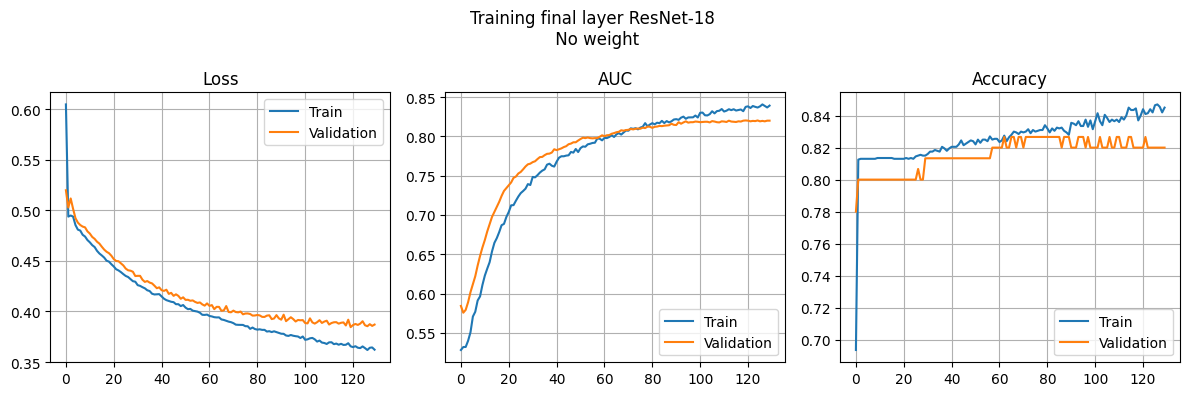

In [ ]:
plot_training(train_losses, train_aucs, train_accs, val_losses, val_aucs, val_accs, suptitle='Training final layer ResNet-18 \n No weight')

In [ ]:
# note that we are testing on the full images, while we trained the model on the compsite images, hence why there is a difference between the test loss and the train/validation loss
test_loss, test_auc, test_acc = test_model(model, test_loader=test_loader, pos_weight=pos_weight)


Test Loss: 0.5172, Test AUC: 0.7067, Test Acc: 0.8067


### With a weighted loss function

#### $\alpha = \frac{\text{N_train}}{\text{sum(Y_train)}}$

In [ ]:
resnet18 = models.resnet18(weights='IMAGENET1K_V1')
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)

model=resnet18.float().to(device) # use float32 to save a bit of memory

In [ ]:
# we now put a weight on the loss
train_losses, train_aucs, train_accs, val_losses, val_aucs, val_accs, best_test_values, pos_weight = train_model(model,
                                                        num_epochs=500, learning_rate=3e-4, patience=10, pos_weight=None, test_on_lowest=True, print_every=2)

Epoch [1/500], Train Loss: 1.4938, Val Loss: 1.4229, Train AUC: 0.4633, Val AUC: 0.4336, Train Acc: 0.7600, Val Acc: 0.5000
Epoch [3/500], Train Loss: 1.2956, Val Loss: 1.3180, Train AUC: 0.4995, Val AUC: 0.4839, Train Acc: 0.2300, Val Acc: 0.2333
Epoch [5/500], Train Loss: 1.2553, Val Loss: 1.2859, Train AUC: 0.5356, Val AUC: 0.5528, Train Acc: 0.4105, Val Acc: 0.5067
Epoch [7/500], Train Loss: 1.2329, Val Loss: 1.2504, Train AUC: 0.5715, Val AUC: 0.6056, Train Acc: 0.4045, Val Acc: 0.4600
Epoch [9/500], Train Loss: 1.2119, Val Loss: 1.2308, Train AUC: 0.6111, Val AUC: 0.6533, Train Acc: 0.4385, Val Acc: 0.5533
Epoch [11/500], Train Loss: 1.1919, Val Loss: 1.2116, Train AUC: 0.6423, Val AUC: 0.6894, Train Acc: 0.4885, Val Acc: 0.5800
Epoch [13/500], Train Loss: 1.1755, Val Loss: 1.1920, Train AUC: 0.6667, Val AUC: 0.7131, Train Acc: 0.4935, Val Acc: 0.5867
Epoch [15/500], Train Loss: 1.1590, Val Loss: 1.1739, Train AUC: 0.6873, Val AUC: 0.7264, Train Acc: 0.5390, Val Acc: 0.6000
Epoch

In [ ]:
print(f'Model was validated as best on epoch {best_test_values[-1]}, reaching a test loss of {best_test_values[0]}'
      f' Test AUC: {best_test_values[1]}, Test Acc: {round(best_test_values[2]*100, 2)}%')

Model was validated as best on epoch 80, reaching a test loss of 1.336427615483602Test AUC: 0.7018987536430359, Test Acc: 78.67%


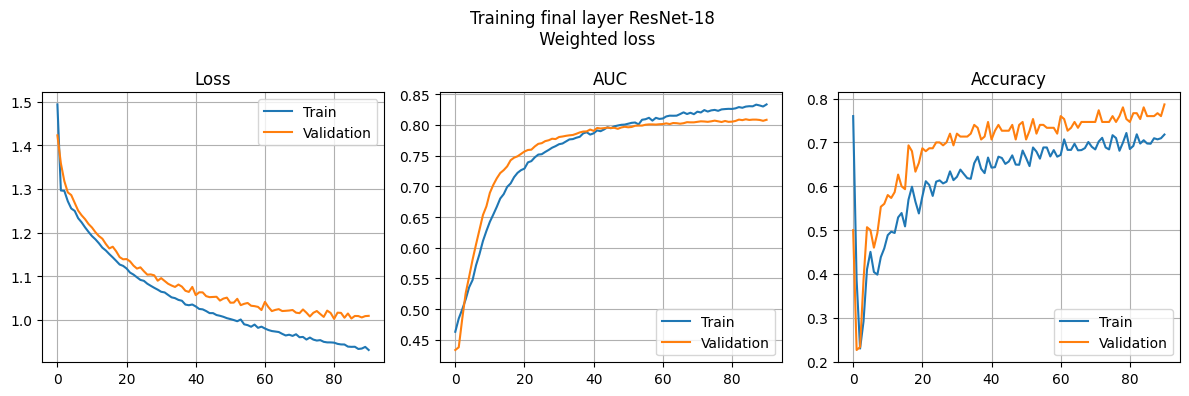

In [ ]:
plot_training(train_losses, train_aucs, train_accs, val_losses, val_aucs, val_accs, suptitle='Training final layer ResNet-18 \n Weighted loss')

In [ ]:
# note that we are testing on the full images, while we trained the model on the compsite images, hence why there is a difference between the test loss and the train/validation loss
test_loss, test_auc, test_acc = test_model(model, test_loader=test_loader, pos_weight=pos_weight)


Test Loss: 1.3972, Test AUC: 0.7032, Test Acc: 0.7900


#### $\alpha = \frac{\text{N_train}}{2 \text{sum(Y_train)}}$

In [ ]:
resnet18 = models.resnet18(weights='IMAGENET1K_V1')
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)

model=resnet18.float().to(device) # use float32 to save a bit of memory

In [ ]:
# we now put a weight on the loss
train_losses, train_aucs, train_accs, val_losses, val_aucs, val_accs, best_test_values, pos_weight = train_model(model, num_epochs=500, learning_rate=3e-4,
                                                                        patience=10, pos_weight=None, alpha_class_weight=2, test_on_lowest=True, print_every=10)

Epoch [1/500], Train Loss: 0.9752, Val Loss: 0.9537, Train AUC: 0.4603, Val AUC: 0.3733, Train Acc: 0.4520, Val Acc: 0.7600
Epoch [11/500], Train Loss: 0.8339, Val Loss: 0.8794, Train AUC: 0.6494, Val AUC: 0.5997, Train Acc: 0.7865, Val Acc: 0.7933
Epoch [21/500], Train Loss: 0.7807, Val Loss: 0.8110, Train AUC: 0.7383, Val AUC: 0.7242, Train Acc: 0.7725, Val Acc: 0.8067
Epoch [31/500], Train Loss: 0.7461, Val Loss: 0.7755, Train AUC: 0.7690, Val AUC: 0.7683, Train Acc: 0.7965, Val Acc: 0.8400
Epoch [41/500], Train Loss: 0.7226, Val Loss: 0.7580, Train AUC: 0.7901, Val AUC: 0.7858, Train Acc: 0.8105, Val Acc: 0.8333
Epoch [51/500], Train Loss: 0.7008, Val Loss: 0.7359, Train AUC: 0.8050, Val AUC: 0.8006, Train Acc: 0.8040, Val Acc: 0.8267
Epoch [61/500], Train Loss: 0.6866, Val Loss: 0.7185, Train AUC: 0.8148, Val AUC: 0.8033, Train Acc: 0.8095, Val Acc: 0.8267
Epoch [71/500], Train Loss: 0.6733, Val Loss: 0.7161, Train AUC: 0.8234, Val AUC: 0.8081, Train Acc: 0.8185, Val Acc: 0.8200
E

In [ ]:
print(f'Model was validated as best on epoch {best_test_values[-1]}, reaching a test loss of {best_test_values[0]}'
      f' Test AUC: {best_test_values[1]}, Test Acc: {round(best_test_values[2]*100, 2)}%')

Model was validated as best on epoch 108, reaching a test loss of 0.9234825412432353 Test AUC: 0.7087116241455078, Test Acc: 81.0%


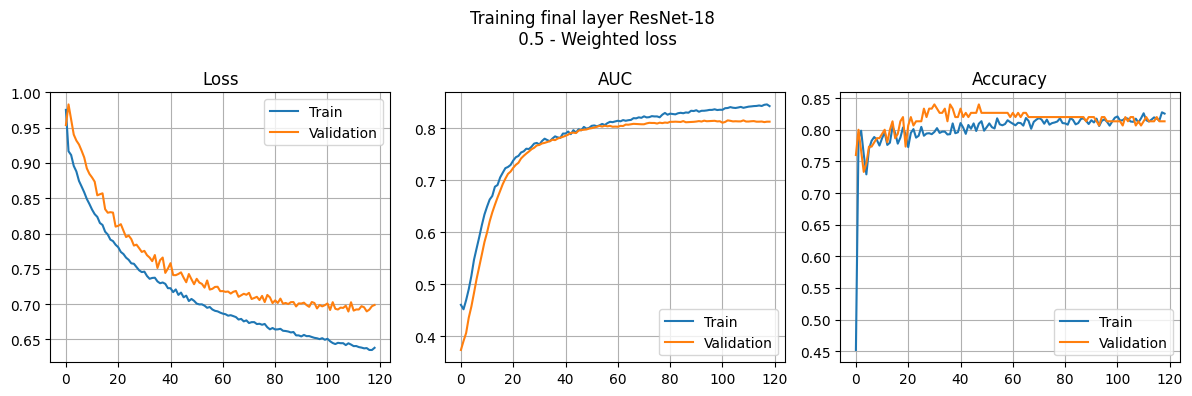

In [ ]:
plot_training(train_losses, train_aucs, train_accs, val_losses, val_aucs, val_accs, suptitle='Training final layer ResNet-18 \n 0.5 - Weighted loss')

In [ ]:
# note that we are testing on the full images, while we trained the model on the compsite images, hence why there is a difference between the test loss and the train/validation loss
test_loss, test_auc, test_acc = test_model(model, test_loader=test_loader, pos_weight=pos_weight)


Test Loss: 0.9610, Test AUC: 0.7060, Test Acc: 0.8117


Now, it's time to retrain the entire network (previously pre-trained on Imagenet)


In [ ]:
for param in resnet18.parameters():
    resnet18.requires_grad = True

# Change last layer, the fully connected layer (classifier)
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)

model = resnet18.float().to(device) # use float32 to save a bit of memory

In [ ]:
# we now put a weight on the loss
train_losses, train_aucs, train_accs, val_losses, val_aucs, val_accs, best_test_values, pos_weight = train_model(model, num_epochs=500, learning_rate=1e-4,
                                                                        patience=10, pos_weight=None, alpha_class_weight=2, test_on_lowest=True, print_every=10)

Epoch [1/500], Train Loss: 0.9611, Val Loss: 0.9497, Train AUC: 0.5346, Val AUC: 0.5156, Train Acc: 0.4190, Val Acc: 0.4867
Epoch [11/500], Train Loss: 0.8511, Val Loss: 0.8765, Train AUC: 0.6046, Val AUC: 0.5978, Train Acc: 0.7705, Val Acc: 0.7733
Epoch [21/500], Train Loss: 0.8218, Val Loss: 0.8415, Train AUC: 0.6729, Val AUC: 0.6736, Train Acc: 0.7920, Val Acc: 0.8133
Epoch [31/500], Train Loss: 0.7964, Val Loss: 0.8139, Train AUC: 0.7178, Val AUC: 0.7181, Train Acc: 0.7935, Val Acc: 0.8333
Epoch [41/500], Train Loss: 0.7786, Val Loss: 0.7938, Train AUC: 0.7398, Val AUC: 0.7411, Train Acc: 0.7965, Val Acc: 0.8333
Epoch [51/500], Train Loss: 0.7612, Val Loss: 0.7783, Train AUC: 0.7597, Val AUC: 0.7553, Train Acc: 0.8010, Val Acc: 0.8267
Epoch [61/500], Train Loss: 0.7504, Val Loss: 0.7656, Train AUC: 0.7680, Val AUC: 0.7631, Train Acc: 0.7960, Val Acc: 0.8333
Epoch [71/500], Train Loss: 0.7387, Val Loss: 0.7551, Train AUC: 0.7776, Val AUC: 0.7731, Train Acc: 0.8040, Val Acc: 0.8400
E

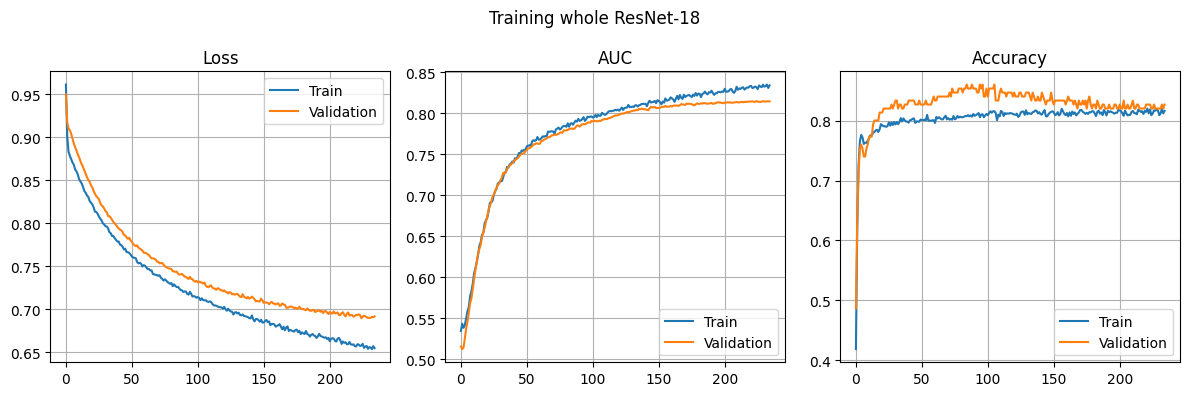

In [ ]:
plot_training(train_losses, train_aucs, train_accs, val_losses, val_aucs, val_accs, suptitle='Training whole ResNet-18')

In [ ]:
test_loss, test_auc, test_acc = test_model(model, test_loader=test_loader, pos_weight=pos_weight)


Test Loss: 0.9149, Test AUC: 0.7098, Test Acc: 0.8133


And eventually train from scratch the network, namely the weights should be randomly initiliazed.

In [ ]:
resnet18 = models.resnet18(weights=None)
# Unfreeze all parameters of the model
for param in resnet18.parameters():
    resnet18.requires_grad = True

# Change last layer, the fully connected layer (classifier)
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)
model = resnet18.float().to(device) # use float32 to save a bit of memory

In [ ]:
# we now put a weight on the loss
train_losses, train_aucs, train_accs, val_losses, val_aucs, val_accs, best_test_values, pos_weight = train_model(model, num_epochs=500, learning_rate=3e-6,
                                                                        patience=20, pos_weight=None, alpha_class_weight=2, test_on_lowest=True, print_every=10)

Epoch [1/500], Train Loss: 0.9746, Val Loss: 0.9503, Train AUC: 0.5498, Val AUC: 0.3672, Train Acc: 0.1880, Val Acc: 0.2000
Epoch [11/500], Train Loss: 0.8537, Val Loss: 0.9225, Train AUC: 0.7768, Val AUC: 0.5325, Train Acc: 0.6765, Val Acc: 0.5333
Epoch [21/500], Train Loss: 0.7760, Val Loss: 0.8913, Train AUC: 0.8460, Val AUC: 0.5947, Train Acc: 0.8365, Val Acc: 0.7400
Epoch [31/500], Train Loss: 0.6926, Val Loss: 0.8739, Train AUC: 0.9040, Val AUC: 0.6422, Train Acc: 0.8675, Val Acc: 0.7400
Epoch [41/500], Train Loss: 0.5799, Val Loss: 0.8610, Train AUC: 0.9617, Val AUC: 0.6597, Train Acc: 0.9180, Val Acc: 0.7133
Epoch [51/500], Train Loss: 0.4317, Val Loss: 0.8390, Train AUC: 0.9960, Val AUC: 0.6872, Train Acc: 0.9635, Val Acc: 0.7200
Epoch [61/500], Train Loss: 0.2777, Val Loss: 0.8414, Train AUC: 1.0000, Val AUC: 0.6800, Train Acc: 0.9865, Val Acc: 0.7467
Epoch [71/500], Train Loss: 0.1763, Val Loss: 0.8780, Train AUC: 1.0000, Val AUC: 0.6697, Train Acc: 0.9990, Val Acc: 0.7667
E

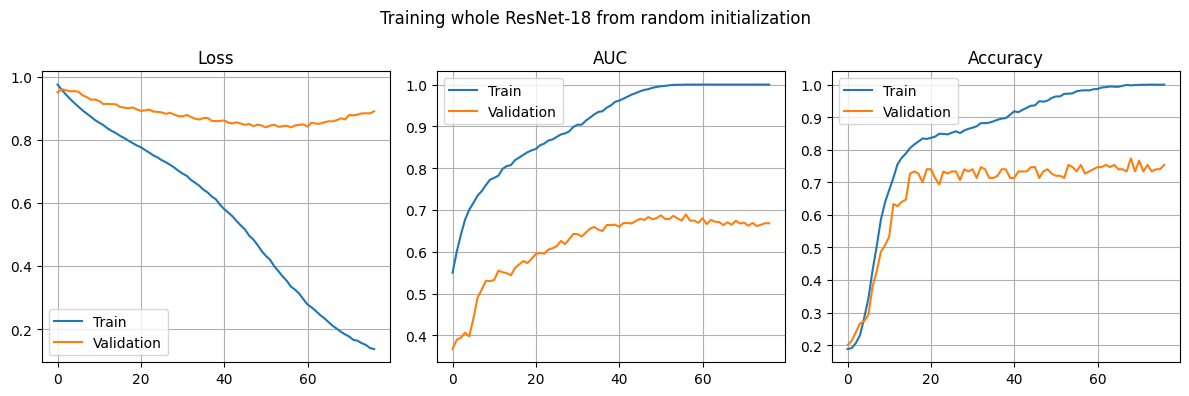

In [ ]:
plot_training(train_losses, train_aucs, train_accs, val_losses, val_aucs, val_accs, suptitle='Training whole ResNet-18 from random initialization')

In [ ]:
test_loss, test_auc, test_acc = test_model(model, test_loader=test_loader, pos_weight=pos_weight)


Test Loss: 1.0555, Test AUC: 0.5960, Test Acc: 0.7433


Clearly, the last attempt to try to retrain the whole network from random initialization did not work well compared to the other cases. The model overfits quite quickly. We can try to make smalled batches to add some form of regularization, use an even smaller learning rate and maybe try and penalize even more the overrepresented class

In [ ]:
train_loader_small = DataLoader(train_dataset, num_workers=1, batch_size=32, shuffle=True)
val_loader_small = DataLoader(val_dataset, num_workers=1, batch_size=32)
test_loader_small = DataLoader(test_dataset, num_workers=1, batch_size=32)

In [ ]:
resnet18 = models.resnet18(weights=None)
# Unfreeze all parameters of the model
for param in resnet18.parameters():
    resnet18.requires_grad = True

# Change last layer, the fully connected layer (classifier)
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)
model = resnet18.float().to(device) # use float32 to save a bit of memory

In [ ]:
train_losses, train_aucs, train_accs, val_losses, val_aucs, val_accs, best_test_values, pos_weight = train_model(model, num_epochs=500, learning_rate=5e-7,
                patience=20, print_every=10, pos_weight=None, alpha_class_weight=1/4,
                train_loader=train_loader_small, val_loader=val_loader_small, test_loader=test_loader_small,
                train_with_composites=True, test_on_lowest=True)

Epoch [1/500], Train Loss: 4.4325, Val Loss: 4.7029, Train AUC: 0.5096, Val AUC: 0.5619, Train Acc: 0.8130, Val Acc: 0.8000
Epoch [11/500], Train Loss: 3.6483, Val Loss: 4.0601, Train AUC: 0.6454, Val AUC: 0.4975, Train Acc: 0.7990, Val Acc: 0.8000
Epoch [21/500], Train Loss: 3.0500, Val Loss: 3.4805, Train AUC: 0.7490, Val AUC: 0.5064, Train Acc: 0.4920, Val Acc: 0.4733
Epoch [31/500], Train Loss: 2.6345, Val Loss: 3.0180, Train AUC: 0.7944, Val AUC: 0.5183, Train Acc: 0.2050, Val Acc: 0.2067
Epoch [41/500], Train Loss: 2.3391, Val Loss: 2.7445, Train AUC: 0.8242, Val AUC: 0.5383, Train Acc: 0.1880, Val Acc: 0.2067
Epoch [51/500], Train Loss: 2.1518, Val Loss: 2.5372, Train AUC: 0.8268, Val AUC: 0.5486, Train Acc: 0.1905, Val Acc: 0.2067
Epoch [61/500], Train Loss: 2.0228, Val Loss: 2.4208, Train AUC: 0.8269, Val AUC: 0.5561, Train Acc: 0.1950, Val Acc: 0.2067
Epoch [71/500], Train Loss: 1.9097, Val Loss: 2.3699, Train AUC: 0.8464, Val AUC: 0.5769, Train Acc: 0.2000, Val Acc: 0.2067
E

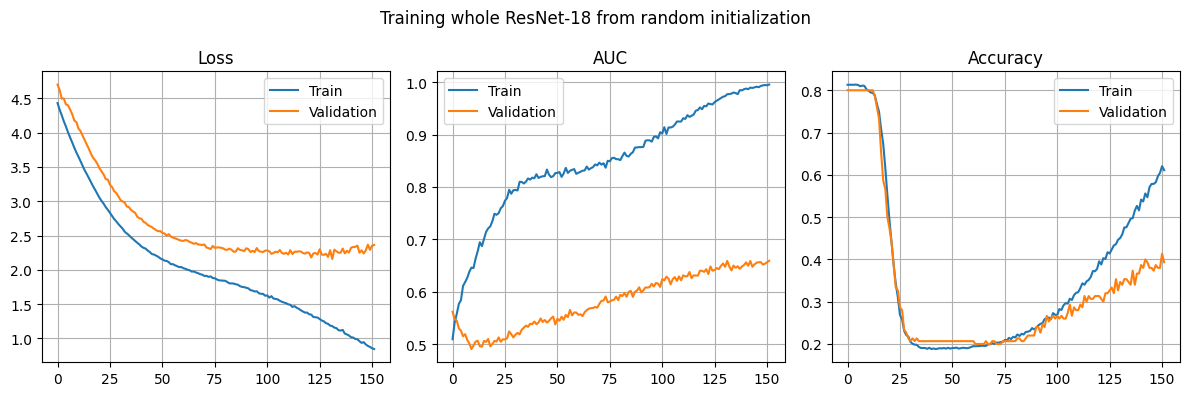

In [ ]:
plot_training(train_losses, train_aucs, train_accs, val_losses, val_aucs, val_accs, suptitle='Training whole ResNet-18 from random initialization')

In [ ]:
test_loss, test_auc, test_acc = test_model(model, train_loader=train_loader_small, test_loader=test_loader_small, pos_weight=pos_weight)


Test Loss: 5.1585, Test AUC: 0.5261, Test Acc: 0.5167


**Question**: Train at least 3 different networks using the three strategies. Use the validation set to compare the performance of the three models and evaluate the best-performing one on the test set. Which is the best strategy ? Are you satisfied ?

In [ ]:
import time

In [ ]:
def train_model_on_mask_or_images(m, strategy, on_images, model, num_epochs, learning_rate, patience, dict_results,
                                 alpha_class_weight=1, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader):
    train_on = 'image' if on_images else 'mask'
    print(f'Train {m} with strategy {strategy} on {train_on}s')
    if dict_results.get(f'{m},{strategy},{train_on}') is not None:
        print(dict_results.get(f'{m},{strategy},{train_on}'))
    else:
        start = time.time()
        train_losses, train_aucs, train_accs, val_losses, val_aucs, val_accs, best_test_values, pos_weight = train_model(model, num_epochs=num_epochs, learning_rate=learning_rate,
                patience=patience, print_every=None, pos_weight=None, alpha_class_weight=alpha_class_weight,
                train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
                train_with_composites=not on_images, test_on_lowest=True)
        test_loss, test_auc, test_acc = test_model(model, train_loader=train_loader, test_loader=test_loader, pos_weight=pos_weight, on_composites=False)
        stop = time.time()
        dict_results[f'{m},{strategy},{train_on}'] = (val_losses[-1], val_aucs[-1], val_accs[-1], min(val_losses), max(val_aucs), max(val_accs), test_loss, test_auc, test_acc, best_test_values[0], best_test_values[1], best_test_values[2], stop-start)
        save_dict(dict_results)
        clear_output(wait=False)

In [ ]:
def load_model(loading_method, strategy):
  def load_model_(grad, weights):
    model = loading_method(weights=weights)
    for param in model.parameters():
      param.requires_grad = grad
    try:
      model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    except:
      model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes) # efficient net has its last layer named 'classifier' not 'fc'
    return model

  if strategy == 'last_layer':
    model = load_model_(grad=False, weights='IMAGENET1K_V1')

  elif strategy == 'whole':
    model = load_model_(grad=True, weights='IMAGENET1K_V1')

  else:
    model = load_model_(grad=False, weights=None)

  model = model.float().to(device) # use float32 to save a bit of memory
  return model

In [ ]:
from google.colab import drive
import pickle

drive.mount('/content/gdrive')

def save_dict(dict_, filename='dict_results.pkl'):
  with open('/content/gdrive/My Drive/DL/Representation Learning/Lab 1/'+filename, 'wb') as f:
    pickle.dump(dict_, f)

def load_dict(filename='dict_results.pkl'):
  with open('/content/gdrive/My Drive/DL/Representation Learning/Lab 1/'+filename, 'rb') as f:
    loaded_dict = pickle.load(f)
  return loaded_dict

Mounted at /content/gdrive


In [ ]:
num_epochs = 500
patience=10

models_ = ['resnet', 'efficientnet', 'googlenet']
strategies = ['last_layer', 'whole', 'random_weights']

dict_results = load_dict()

for m in models_:
  if m == 'resnet':
    loading_method = models.resnet18
  elif m == 'googlenet':
    loading_method = models.googlenet
  else:
    loading_method = models.efficientnet_b1

  # 1. Fine-Tune last classification layer
  model = load_model(loading_method, 'last_layer')
  train_model_on_mask_or_images(m, 'last_layer', False, model, num_epochs, learning_rate=3e-4, patience=patience, dict_results=dict_results)
  clear_output(wait=False)

  torch.cuda.empty_cache()
  model = load_model(loading_method, 'last_layer')
  train_model_on_mask_or_images(m, 'last_layer', True, model, num_epochs, learning_rate=3e-4, patience=patience, dict_results=dict_results)
  clear_output(wait=False)

  # 2. Train the whole model, initialized with pre-trained weights
  torch.cuda.empty_cache()
  model = load_model(loading_method, 'whole')
  train_model_on_mask_or_images(m, 'whole', False, model, num_epochs, learning_rate=1e-4, patience=patience, dict_results=dict_results)
  clear_output(wait=False)

  torch.cuda.empty_cache()
  model = load_model(loading_method, 'whole')
  train_model_on_mask_or_images(m, 'whole', True, model, num_epochs, learning_rate=1e-4, patience=patience, dict_results=dict_results)
  clear_output(wait=False)

  # 2. Train the whole model, initialized with pre-trained weights
  torch.cuda.empty_cache()
  model = load_model(loading_method, 'random_weights')
  train_model_on_mask_or_images(m, 'random_weights', False, model, num_epochs, learning_rate=1e-6, patience=2*patience, dict_results=dict_results)
  clear_output(wait=False)

  torch.cuda.empty_cache()
  model = load_model(loading_method, 'random_weights')
  train_model_on_mask_or_images(m, 'random_weights', True, model, num_epochs, learning_rate=1e-6, patience=2*patience, dict_results=dict_results)
  clear_output(wait=False)

In [ ]:
import pandas as pd

dict_results = load_dict()

"""
Columns:
- val_loss: the value of the validation loss on the last epoch of training of the model (might have overfitted by this point)
- val_AUC: the validation AUC score on the last epoch of training of the model (might have overfitted by this point)
- val_accuracy: the accuracy over the validation set on the last epoch of training of the model (might have overfitted by this point)

- min_val_loss: the minimum validation loss reached during training
- max_val_AUC: the AUC score over the validation set reached at the epoch where the validation loss was minimum
- max_val_accuracy: the accuracy over the validation set reached at the epoch where the validation loss was minimum

- test_loss: loss over the test set, after training
- test_AUC: AUC score over the test set, after training
- test_accuracy: accuracy over the test set, after training

- test_loss_best_val: loss over the test set, at the epoch where the validation loss was minimum
- test_AUC_best_val: AUC score over the test set, at the epoch where the validation loss was minimum
- test_accuracy_best_val: accuracy over the test set, at the epoch where the validation loss was minimum

- train time (s): total time, in seconds, to train and test the model
This may not be representative if used to compare different strategies as the learning rates and patience values where different.
However, can be used to compare the training over full images and masks, and compare the training between the different model architectures (ResNet, GoogleNet, EfficientNet)

Index:
the index is constructed as such: {model}, {strategy}, {training_type} with
   - model: varies in [resnet, googlenet, efficientnet]: represents the architecture used for the model
   - strategy: varies in [last_layer, whole, random_weights]
              • last_layer -> the model is initialized with pre-trained weights, all layers have frozen weights except the last layer
              • whole -> the model is initialized with pre-trained weight, but all the weights are being trained, no weight is frozen
              • random_weights -> the model has weights that are randomly initialized, and all the weights are being trained, no weight is frozen
"""

df_results = pd.DataFrame.from_dict(dict_results, orient='index')
df_results.columns = ['val_loss', 'val_AUC', 'val_accuracy', 'min_val_loss', 'max_val_AUC', 'max_val_accuracy', 'test_loss', 'test_AUC', 'test_accuracy', 'test_loss_best_val', 'test_AUC_best_val', 'test_accuracy_best_val', 'train time (s)']
df_results

,val_loss,val_AUC,val_accuracy,min_val_loss,max_val_AUC,max_val_accuracy,test_loss,test_AUC,test_accuracy,test_loss_best_val,test_AUC_best_val,test_accuracy_best_val,train time (s)
"resnet,last_layer,image",1.002512,0.804722,0.793333,0.991606,0.819444,0.793333,1.057017,0.763727,0.643333,1.062440,0.760525,0.620000,696.371356
"resnet,whole,image",1.542391,0.893056,0.886667,0.812616,0.896667,0.886667,1.568483,0.842756,0.835000,0.912620,0.838350,0.748333,177.754351
"resnet,random_weights,mask",1.294080,0.435833,0.200000,1.279740,0.484722,0.200000,1.261877,0.548371,0.205000,1.270523,0.489480,0.198333,244.898044
"resnet,random_weights,image",1.262107,0.577500,0.200000,1.261496,0.579722,0.206667,1.263925,0.516537,0.196667,1.265482,0.510078,0.196667,397.696295
"googlenet,last_layer,mask",1.092256,0.761944,0.706667,1.090394,0.763056,0.713333,1.275958,0.678912,0.726667,1.260266,0.679496,0.720000,958.619677
"googlenet,last_layer,image",1.050340,0.781944,0.720000,1.042682,0.783611,0.740000,1.024961,0.786307,0.701667,1.025327,0.787723,0.673333,1052.069135
"googlenet,whole,mask",1.794464,0.788056,0.866667,1.083109,0.791944,0.866667,1.670934,0.734830,0.808333,1.129201,0.735060,0.633333,190.873508
"googlenet,whole,image",1.530890,0.864444,0.846667,1.059436,0.864722,0.866667,1.274922,0.845393,0.833333,0.949137,0.844137,0.810000,204.322175
"efficientnet,last_layer,mask",1.063345,0.793611,0.733333,1.054104,0.794444,0.733333,1.141471,0.733928,0.701667,1.137714,0.734636,0.688333,1263.434891
"efficientnet,last_layer,image",0.938286,0.850278,0.793333,0.930822,0.865556,0.800000,1.006708,0.797208,0.650000,1.010727,0.797172,0.650000,1041.506636


## Questions

**Question**: Train at least 3 different networks using the three strategies. Use the validation set to compare the performance of the three models and evaluate the best-performing one on the test set. Which is the best strategy ? Are you satisfied ?

In [ ]:
# Sorting the dataframe based on 'val_AUC'
sorted_df = df_results.sort_values(by='test_AUC_best_val', ascending=False)

sorted_df

,val_loss,val_AUC,val_accuracy,min_val_loss,max_val_AUC,max_val_accuracy,test_loss,test_AUC,test_accuracy,test_loss_best_val,test_AUC_best_val,test_accuracy_best_val,train time (s)
"googlenet,whole,image",1.530890,0.864444,0.846667,1.059436,0.864722,0.866667,1.274922,0.845393,0.833333,0.949137,0.844137,0.810000,204.322175
"resnet,whole,image",1.542391,0.893056,0.886667,0.812616,0.896667,0.886667,1.568483,0.842756,0.835000,0.912620,0.838350,0.748333,177.754351
"efficientnet,whole,image",2.350800,0.816389,0.793333,0.916723,0.871944,0.853333,1.651799,0.833740,0.845000,0.941890,0.831626,0.781667,172.798129
"efficientnet,last_layer,image",0.938286,0.850278,0.793333,0.930822,0.865556,0.800000,1.006708,0.797208,0.650000,1.010727,0.797172,0.650000,1041.506636
"googlenet,last_layer,image",1.050340,0.781944,0.720000,1.042682,0.783611,0.740000,1.024961,0.786307,0.701667,1.025327,0.787723,0.673333,1052.069135
"efficientnet,whole,mask",1.939927,0.801389,0.866667,0.921306,0.874722,0.886667,3.337019,0.747147,0.813333,1.138219,0.766152,0.775000,160.050075
"resnet,last_layer,image",1.002512,0.804722,0.793333,0.991606,0.819444,0.793333,1.057017,0.763727,0.643333,1.062440,0.760525,0.620000,696.371356
"googlenet,whole,mask",1.794464,0.788056,0.866667,1.083109,0.791944,0.866667,1.670934,0.734830,0.808333,1.129201,0.735060,0.633333,190.873508
"efficientnet,last_layer,mask",1.063345,0.793611,0.733333,1.054104,0.794444,0.733333,1.141471,0.733928,0.701667,1.137714,0.734636,0.688333,1263.434891
"resnet,last_layer,mask",0.989191,0.820556,0.760000,0.978954,0.821667,0.773333,1.532888,0.698519,0.800000,1.463424,0.700731,0.798333,1086.788976


In [ ]:
nb_params_resnet = sum(p.numel() for p in models.resnet18(weights='IMAGENET1K_V1').parameters())
nb_params_googlenet = sum(p.numel() for p in models.googlenet(weights='IMAGENET1K_V1').parameters())
nb_params_efficientnet = sum(p.numel() for p in models.efficientnet_b1(weights='IMAGENET1K_V1').parameters())

print(f'Number of parameters in ResNet-18: {nb_params_resnet:,}')
print(f'Number of parameters in GoogleNet: {nb_params_googlenet:,}')
print(f'Number of parameters in EfficientNet-B1: {nb_params_efficientnet:,}')

Number of parameters in ResNet-18: 11,689,512
Number of parameters in GoogleNet: 6,624,904
Number of parameters in EfficientNet-B1: 7,794,184


I used the architecture of 3 famous CNNs: ResNet-18, GoogleNet and EfficientNet_B1, the last two mostly motvated by the fact that these models achieved near state-of-the-art performances, despite not having too many parameters like models like VGG or Visual Transformers.

The dataframe above was sorted by the loss value over the test set, reached at the epoch where the validation loss was minimal. Because I had set a fairly high patience level, the models have probably overfitted by the end of the training, and thus the validation/test loss after training is not the most representative. <br>
Using the test loss on the best epoch, we can see that the 3 models achieve equivalent performances, with GoogleNet getting a slightly better AUC. <br>
We can see that the best approach seems to start from the pre-trained weights, but not freeze them and retrain them. Freezing the convolutional layers and training only the fully connected layer works alright, yet not as well as training all the layers. <br>
However, we do not have enough images to train a very deep architectures like the ones we used. We can see that the model overfits immediatly and has very bad AUC scores and the train/test sets, despite using very low values for the learning rate.

The results we get when loading the model with pre-trained weights and training every layer are pretty good, with AUC scores around 0.85 for the test set on the best epochs and almost 0.90 for the validation set. If we remember, the AUC scores we got for the ML models with extracted features were around 0.65 for the best models, so this Deep Learning approach works clearly better.

Spending more time and tuning the architecture even more could maybe even give us better results.

However, there is a compromise to make to do Deep Learning. Creating a model architecture and coding the training methodology is quite quick, much quicker than it was to code the feature extractions for ML models. However, once the feature are extracted, fitting an ML model is uch quicker and does not demand heavy resources, while we can see that it took quite some time to train the Deep Learning models, and it demanded acces to GPUs.

**Question**: You can use as input to your model either the full image or the masked image. Compare the two strategies by testing *in both cases* only on the full images (assume that you do not have the segmentation masks at test time). In this way, the comparison will be more fair. What's better ?

In [ ]:
df_results_image = df_results.loc[df_results.index.str.endswith('image')]
df_results_mask = df_results.loc[df_results.index.str.endswith('mask')]

In [ ]:
print(f'On images, on the best epoch, test AUC on the test on average is     {df_results_image.test_AUC_best_val.mean()}')
print(f'On composites, on the best epoch, test AUC on the test on average is {df_results_mask.test_AUC_best_val.mean()}')
print()
print(f'On images, on the best epoch, test loss on the test on average is     {df_results_image.test_loss_best_val.mean()}')
print(f'On composites, on the best epoch, test loss on the test on average is {df_results_mask.test_loss_best_val.mean()}')
print()
print(f'On images, on the best epoch, validation AUC on the test on average is     {df_results_image.max_val_AUC.mean()}')
print(f'On composites, on the best epoch, validation AUC on the test on average is {df_results_mask.max_val_AUC.mean()}')
print()
print(f'On images, on the best epoch, validation loss on the test on average is     {df_results_image.min_val_loss.mean()}')
print(f'On composites, on the best epoch, validation loss on the test on average is {df_results_mask.min_val_loss.mean()}')

On images, on the best epoch, test AUC on the test on average is     0.7042965094248453
On composites, on the best epoch, test AUC on the test on average is 0.643552197350396

On images, on the best epoch, test loss on the test on average is     1.0810361938123352
On composites, on the best epoch, test loss on the test on average is 1.2595006059717249

On images, on the best epoch, validation AUC on the test on average is     0.7712191277080112
On composites, on the best epoch, validation AUC on the test on average is 0.7263580229547288

On images, on the best epoch, validation loss on the test on average is     1.065737193160587
On composites, on the best epoch, validation loss on the test on average is 1.0975894374317592


We can see that clearly, the best strategy is to train on the images. Training on the composites to then test on the full images returns very bad results. Hiding information from the original images does not work well for the classification task, it works better the feed the CNN the whole image and let it adjust its filters and weights to best interpret the images.

**Question**: Plot on a graph the time you have spent (x-axis) and the maximum AUC (y-axis) for all strategies you tried: feature engineering and DL fie-tuning or training. What's your conclusion ?

In [ ]:
dict_times = {}

# Best AUC feature engineering
time_feature_engineering = (7*60+15)*60 # ~7h15 in total
AUC_feature_engineering = 0.65
dict_times['feature engineering'] = [time_feature_engineering, AUC_feature_engineering]

best_model_DL_training__time = sorted_df.iloc[0]['train time (s)']
best_model_DL_training__AUC = sorted_df.iloc[0]['test_AUC_best_val']
dict_times['DL training'] = [best_model_DL_training__time, best_model_DL_training__AUC]

df_finetuning = df_results.loc[df_results.index.str.contains('last_layer')].sort_values(by='test_AUC_best_val', ascending=False)
best_model_DL_finetuning__time = df_finetuning.iloc[0]['train time (s)']
best_model_DL_finetuning__AUC = df_finetuning.iloc[0]['test_AUC_best_val']
dict_times['DL fine-tuning'] = [best_model_DL_finetuning__time, best_model_DL_training__AUC]

In [ ]:
dict_times

{'feature engineering': [26100, 0.65],
 'DL training': [204.32217478752136, 0.8441365361213684],
 'DL fine-tuning': [1041.5066363811493, 0.8441365361213684]}

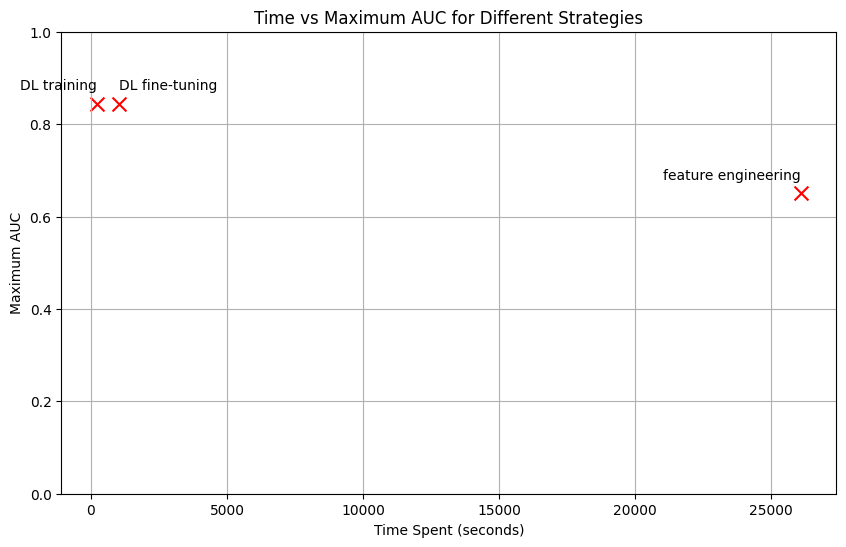

In [ ]:
labels = list(dict_times.keys())
time_spent = [entry[0] for entry in dict_times.values()]
max_auc = [entry[1] for entry in dict_times.values()]

plt.figure(figsize=(10, 6))
plt.scatter(time_spent, max_auc, color='red', s=100, marker='x')

plt.xlabel('Time Spent (seconds)')
plt.ylabel('Maximum AUC')
plt.title('Time vs Maximum AUC for Different Strategies')

plt.ylim([0, 1])

# Annotating points with strategy labels
for i, label in enumerate(labels):
    plt.annotate(label, (time_spent[i], max_auc[i]), textcoords="offset points", xytext=(0,10), ha='right' if label != 'DL fine-tuning' else 'left')

plt.grid('on')
plt.show()

The conclusion is quite clear and straightforward: the manual feature engineering took a lot of time and energy to put together, and still did not achieve great results. On the other hand, setting the deep learning methods was quite easy and quick, so much so that it made it possible to set up and test different architectures to try which one wotked best on our data. And the results we got from Deep Learning solutions definitely outclassed those from feature engineering.

However, one thing that we lose with Deep Learning approaches is the easy explainability: as we manually extracted features when doing feature engineering, we can explain exactly what is happening and how to explain the results we get. On the other hand, it is still possible to explain the Deep Learning results, but it is harder and not as clear as the explainability from feature engineering.